In [1]:
import math
import matplotlib.pyplot as plt
import arviz as az

import numpy as np
import pandas as pd

import hdbscan
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

## Loading the gaia data for M67

In [2]:
FILENAME = "gaiaedr3_150_M67.csv"
datafile = pd.read_csv(FILENAME, delimiter=",")

In [3]:
datafile.head()

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,...,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error
0,603712422876575360,135.110808,0.179466,10.726941,0.144282,0.286789,0.189191,1.515865,1.814069,-0.675509,...,1.200222,18.423365,394.940086,7.716585,18.847214,574.873237,6.093434,17.848965,NaN,NaN
1,603712427171528448,135.118378,0.223748,10.723134,0.181216,0.051501,0.257076,0.200335,6.170623,-5.506968,...,22.767496,15.028518,9540.077355,15.731504,15.389663,13160.737711,19.746544,14.449695,NaN,NaN
2,603712457236324224,135.121338,0.523702,10.738075,0.395677,-0.012734,0.626520,-0.020324,14.416777,4.077665,...,0.745875,20.152782,72.474297,6.497540,20.688082,138.347415,8.024095,19.395468,NaN,NaN
3,603712560315544576,135.130346,0.903004,10.744922,0.761642,0.781963,0.969796,0.806316,1.470843,-0.476772,...,0.728559,20.612862,44.232127,6.761984,21.224197,102.227884,8.291773,19.723972,NaN,NaN
4,603713041351907200,135.140797,0.335336,10.772432,0.245219,0.951278,0.423789,2.244700,8.649885,-8.469014,...,30.743560,16.465595,2937.308732,11.487564,16.668669,4254.577059,11.557065,15.675755,NaN,NaN


$\textbf{Here we remove sources with NaN values}$

In [4]:
datafile.dropna(subset=['pmra', 'pmdec', 'parallax']).reset_index()

,index,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,...,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error
0,0,603712422876575360,135.110808,0.179466,10.726941,0.144282,0.286789,0.189191,1.515865,1.814069,...,1.200222,18.423365,394.940086,7.716585,18.847214,574.873237,6.093434,17.848965,NaN,NaN
1,1,603712427171528448,135.118378,0.223748,10.723134,0.181216,0.051501,0.257076,0.200335,6.170623,...,22.767496,15.028518,9540.077355,15.731504,15.389663,13160.737711,19.746544,14.449695,NaN,NaN
2,2,603712457236324224,135.121338,0.523702,10.738075,0.395677,-0.012734,0.626520,-0.020324,14.416777,...,0.745875,20.152782,72.474297,6.497540,20.688082,138.347415,8.024095,19.395468,NaN,NaN
3,3,603712560315544576,135.130346,0.903004,10.744922,0.761642,0.781963,0.969796,0.806316,1.470843,...,0.728559,20.612862,44.232127,6.761984,21.224197,102.227884,8.291773,19.723972,NaN,NaN
4,4,603713041351907200,135.140797,0.335336,10.772432,0.245219,0.951278,0.423789,2.244700,8.649885,...,30.743560,16.465595,2937.308732,11.487564,16.668669,4254.577059,11.557065,15.675755,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95579,115665,603622950118859520,135.003350,1.049273,10.782234,0.879750,0.584927,1.131570,0.516916,10.016977,...,0.874115,20.763254,46.211559,6.517455,21.176666,119.069104,11.354191,19.558397,NaN,NaN
95580,115666,603623018837269632,134.996200,0.473971,10.786565,0.392199,-0.134166,0.499585,-0.268555,4.335729,...,0.802039,20.045258,93.905349,10.996089,20.406816,168.347676,7.198842,19.182377,NaN,NaN
95581,115667,603623018837270016,134.986138,0.489632,10.790086,0.348764,1.001567,0.589709,1.698409,17.389887,...,0.666937,20.240751,41.277856,5.681590,21.299250,190.096579,7.743901,19.050459,NaN,NaN
95582,115668,603623053197008512,134.998781,0.346450,10.791484,0.283039,0.518023,0.360595,1.436578,8.223231,...,0.799754,19.531996,93.553167,7.192426,20.410896,274.355026,7.375343,18.652113,NaN,NaN


## Eliminating sources with high uncertainty

In [5]:
datafile['e_Gmag'] = abs(-2.5*datafile['phot_g_mean_flux_error']/math.log(10)/datafile['phot_g_mean_flux'])
datafile['e_BPmag'] = abs(-2.5*datafile['phot_bp_mean_flux_error']/math.log(10)/datafile['phot_bp_mean_flux'])
datafile['e_RPmag'] = abs(-2.5*datafile['phot_rp_mean_flux_error']/math.log(10)/datafile['phot_rp_mean_flux'])

In [6]:
datafile['bp_rp'] = datafile['phot_bp_mean_mag'] - datafile['phot_rp_mean_mag']

In [7]:
data = datafile[(datafile['parallax'] > 0.) & (datafile['e_Gmag'] < 0.005)].reset_index(drop=True)

## Visualization (Cleaned Data)

$\textbf{Spatial Distribution}$

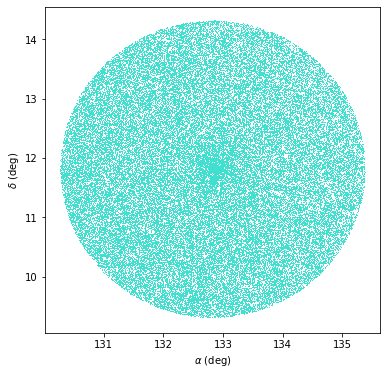

In [8]:
fig = plt.figure(figsize=(6, 6))
plt.plot(data['ra'], data['dec'], ',', color='turquoise')

plt.xlabel(r'$\alpha$ (deg)')
plt.ylabel(r'$\delta$ (deg)')

plt.show()

$\textbf{Vector Point Diagram}$

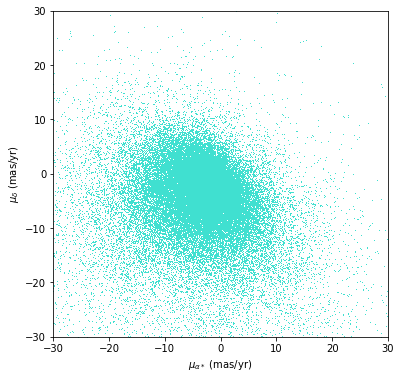

In [9]:
fig = plt.figure(figsize=(6, 6))
plt.plot(data['pmra'], data['pmdec'], ',', color='turquoise')

plt.xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')

plt.xlim(-30,30)
plt.ylim(-30,30)

plt.show()

$\textbf{Color Magnitude Diagram}$

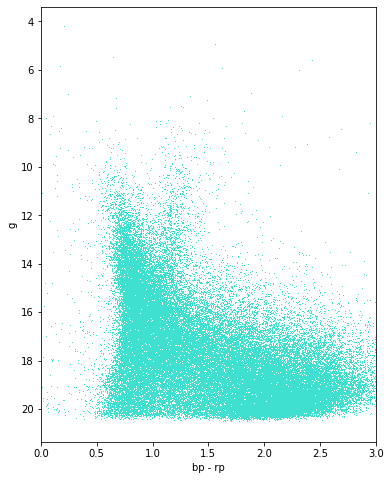

In [10]:
fig = plt.figure(figsize=(6, 8))
plt.plot(data['bp_rp'], data['phot_g_mean_mag'], ',', color='turquoise')

ax = plt.gca()
ax.invert_yaxis()
plt.xlim(0., 3.)

plt.xlabel('bp - rp')
plt.ylabel('g')

plt.show()

## Using HDBSCAN to determine members of m67

Here we normalize the data

In [11]:
df = data[["pmra", "pmdec", "parallax"]]
df = df.to_numpy().astype("float32", copy = False)
stscaler_df = StandardScaler().fit(df)
df_ = stscaler_df.transform(df)

Here we classify using HDBSCAN

In [12]:
clus_size = 2 * df_.shape[1]

In [13]:
clusterer = hdbscan.HDBSCAN(clus_size)
cluster_labels = clusterer.fit_predict(df_)

data['hdbscan'] = cluster_labels

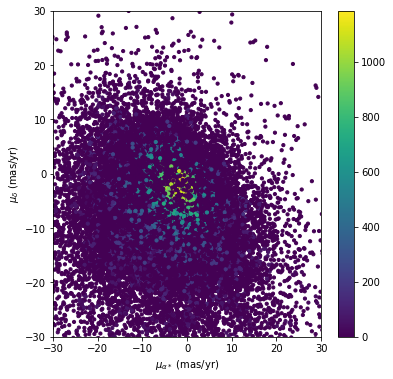

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
gr = ax.scatter(data['pmra'], data['pmdec'], s=10, c=data['hdbscan'])

fig.colorbar(gr, ax=ax)
ax = plt.gca()
ax.invert_yaxis()
plt.xlim(-30,30)
plt.ylim(-30,30)

plt.xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')

plt.show()

Distribution of group labels of all data

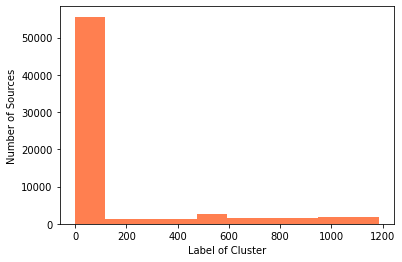

In [15]:
plt.figure(figsize=(6, 4))
plt.hist(data['hdbscan'],color='coral')

plt.xlabel('Label of Cluster')
plt.ylabel('Number of Sources')

plt.show()

The number of members from each clustering result.

In [16]:
data['hdbscan'].value_counts()

-1       54490
 537      1422
 677        84
 1143       70
 176        53
         ...  
 457         6
 258         6
 501         6
 367         6
 440         6
Name: hdbscan, Length: 1188, dtype: int64

Separating the data with a label that shows the background data (`label = -1`)

In [17]:
result_hdbscan = data[data['hdbscan'] >= 0].reset_index(drop=True)

c = result_hdbscan['hdbscan'].value_counts()

Finding the cluster with the most number. Assuming the data used only consists of the background and one stellar cluster.

In [18]:
n_max = c.index[np.argmax(c)]

result = data[data['hdbscan'] == n_max]
result.shape[0]

1422

# Visualization (Result)

## Spatial Distribution

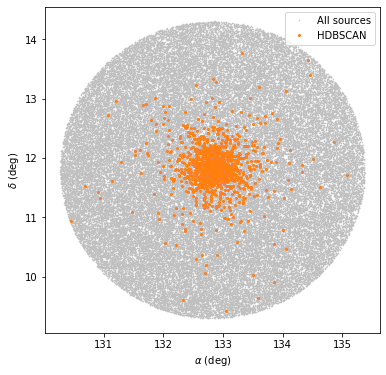

In [19]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
plt.plot(data['ra'], data['dec'], '.', mec='silver', mfc='darkgray', markersize=1., label="All sources")
plt.plot(result['ra'], result['dec'], 'o', mfc='coral', markersize=2., label="HDBSCAN")

plt.xlabel(r'$\alpha$ (deg)')
plt.ylabel(r'$\delta$ (deg)')
plt.legend()
plt.show()

## Vector Point Diagram

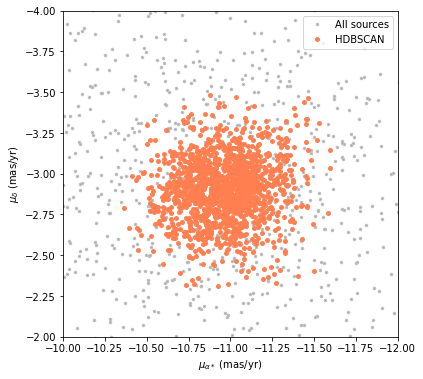

In [20]:
fig = plt.figure(figsize=(6, 6))
plt.plot(data['pmra'], data['pmdec'], '.', mec='silver', mfc='darkgray', markersize=5., label="All sources")
plt.plot(result['pmra'], result['pmdec'], 'o', mfc='coral', mec='None', markersize=5., label="HDBSCAN")

plt.xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')

plt.xticks()
plt.yticks()

plt.xlim(-10,-12)
plt.ylim(-2,-4)

plt.legend()
plt.show()

## Color Magnitude Diagram

In [21]:
data['abs_mag'] = 5*np.log10(data['parallax']) - 10 + data['phot_g_mean_mag']
result['abs_mag'] = 5*np.log10(result['parallax']) - 10 + result['phot_g_mean_mag']

/tmp/ipykernel_9648/1853781592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['abs_mag'] = 5*np.log10(result['parallax']) - 10 + result['phot_g_mean_mag']


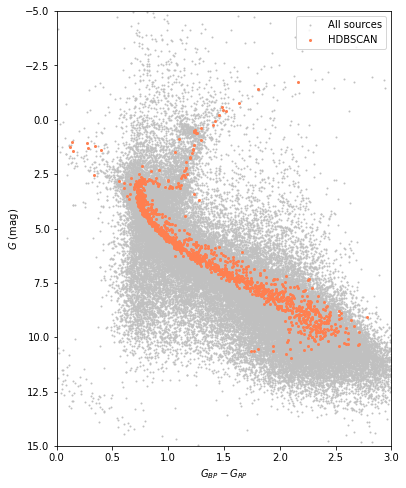

In [22]:
plt.figure(figsize=(6, 8))
plt.plot(data['bp_rp'], data['abs_mag'], '.', mec='silver', mfc='darkgray', markersize=2., label="All sources")
plt.plot(result['bp_rp'], result['abs_mag'], 'o', color='coral', markersize=2., label=r"HDBSCAN")

plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$G$ (mag)')

plt.xlim(0., 3.)
plt.ylim(-5, 15)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## Parallax Distribution

In [23]:
bins_all = np.arange(data['parallax'].min(), data['parallax'].max(), .01)
bins_sam = np.arange(result['parallax'].min(), result['parallax'].max(), .01)

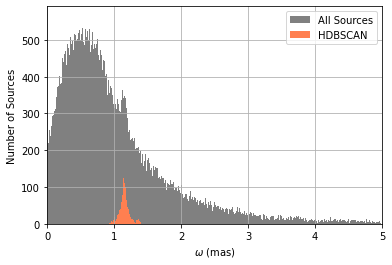

In [24]:
plt.figure(figsize=(6, 4))
data.parallax.hist(bins=bins_all, color='gray', label="All Sources")
result.parallax.hist(bins=bins_sam, color='coral', label="HDBSCAN")

plt.xlabel(r'$\omega$ (mas)')
plt.ylabel('Number of Sources')

plt.xlim(0, 5)

plt.xticks()
plt.yticks()

plt.legend()
plt.show()

## Loading the best-fit isochrone generated from CMD 3.5 input form

In [25]:
##for metal fraction Z = 0.021 and log(age/yr) = 9.6

f1 = open('m67-isochrone13.dat')
header = f1.readlines()[12]
header = header.split()[1:]

data_ = np.loadtxt('m67-isochrone13.dat')

df1 = pd.DataFrame(data_, columns=header)

# #df1.info()

In [26]:
df1['bp_rp'] = df1['G_BPmag'] - df1['G_RPmag']

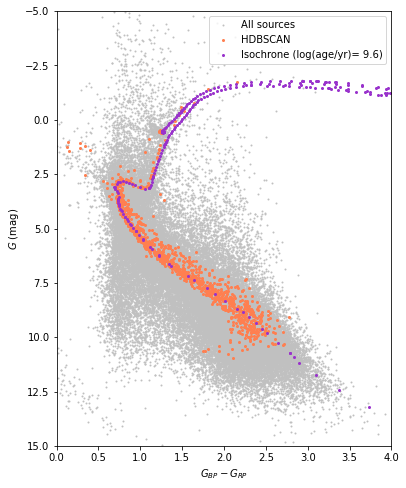

In [131]:
plt.figure(figsize=(6, 8))
plt.plot(data['bp_rp'], data['abs_mag'], '.', mec='silver', mfc='darkgray', markersize=2., label="All sources")
plt.plot(result['bp_rp'], result['abs_mag'], 'o', color='coral', markersize=2., label=r"HDBSCAN")
plt.plot(df1['bp_rp'], df1['Gmag'], 'o', color='darkorchid', markersize=2., label=r"Isochrone (log(age/yr)= 9.6)")


plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$G$ (mag)')

plt.xlim(0., 4.)
plt.ylim(-5, 15)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

$\textbf{We generated this best fit isochrone using 9.6 in log(age/yr). So we can determine it's age.}$

In [66]:
age = 10**9.6
b_age = age/(10**9)
print("The age of the cluster is {0:1.2f} billion years".format(b_age))

The age of the cluster is 3.98 billion years


## Determining the distance of m67

In [54]:
distance = (1/result['parallax'].values)*1000 #because the parallax values are in mas
bins_dis = np.arange(distance.min(), distance.max(), 15)

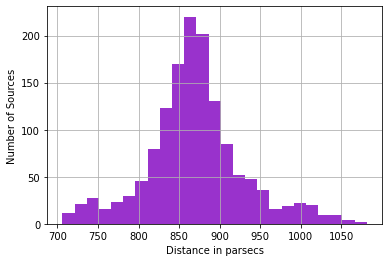

In [55]:
plt.figure(figsize=(6, 4))
plt.hist(distance,bins= bins_dis, color = 'darkorchid')

plt.xlabel('Distance in parsecs')
plt.ylabel('Number of Sources')

plt.grid(True)
plt.show()

In [56]:
n_dis, bins_dis = np.histogram(distance)
mids_dis = 0.5*(bins_dis[1:] + bins_dis[:-1])
mean_dis = np.average(mids_dis, weights=n_dis)
std_dis = np.sqrt(np.average((mids_dis - mean_dis)**2, weights=n_dis))

print("Distance of the cluster is {0:1.2f} +- {1:1.2f} parsecs".format(mean_dis,std_dis))

Distance of the cluster is 870.35 +- 61.58 parsecs


## Determining the center of m67

<Figure size 432x288 with 0 Axes>

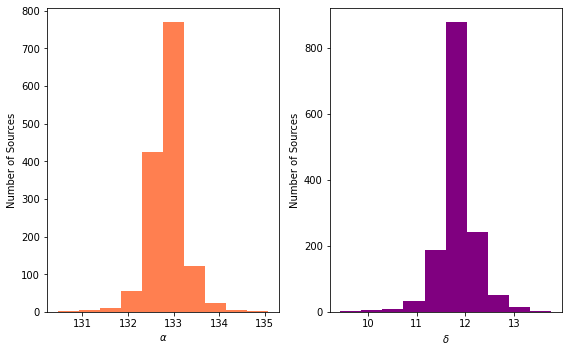

In [80]:
fig = plt.figure()
fig, axs = plt.subplots(1,2,figsize=(8,5))
axs[0].hist(result['ra'], color = 'coral')
axs[0].set_ylabel('Number of Sources')
axs[0].set_xlabel(r'$\alpha$')
axs[1].hist(result['dec'], color = 'purple')
axs[1].set_ylabel('Number of Sources')
axs[1].set_xlabel(r'$\delta$')

plt.tight_layout()
plt.show()

In [86]:
n_ra, bins_ra = np.histogram(result['ra'])
mids_ra = 0.5*(bins_ra[1:] + bins_ra[:-1])
mean_ra = np.average(mids_ra, weights=n_ra)
std_ra = np.sqrt(np.average((mids_ra - mean_ra)**2, weights=n_ra))

n_dec, bins_dec = np.histogram(result['dec'])
mids_dec = 0.5*(bins_dec[1:] + bins_dec[:-1])
mean_dec = np.average(mids_dec, weights=n_dec)
std_dec = np.sqrt(np.average((mids_dec - mean_dec)**2, weights=n_dec))

print("The Center of the cluster is at RA = {0:1.2f} +-{1:1.2f}, DEC = {2:1.2f} +-{3:1.2f}".format(mean_ra,std_ra,mean_dec,std_dec))

The Center of the cluster is at RA = 132.87 +-0.41, DEC = 11.84 +-0.39


## Isochrone fitting with splines

In [123]:
from patsy import dmatrix
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

In [124]:
main = result[(result['abs_mag'] > 4) & (result['abs_mag'] < 10)].reset_index(drop=True)

x = np.array(main['bp_rp'])
y = np.array(main['abs_mag'])

In [125]:
data_x = x
data_y = y

# Dividing data into train and validation datasets
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=0.25, random_state = 1)

<Figure size 504x576 with 0 Axes>

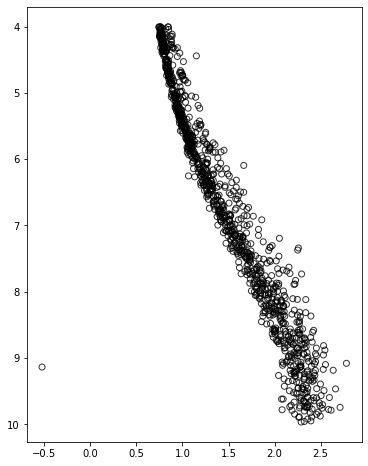

In [126]:
# Visualize the relationship

plt.figure(figsize=(7,8))
plt.figure(figsize=(6, 8))
plt.scatter(data_x, data_y, facecolor='None', edgecolor='k', alpha=0.8)
plt.gca().invert_yaxis()


In [127]:
X_train,X_test,y_train,y_test = train_test_split(data_x, data_y, test_size=0.3, random_state = 11343)

In [128]:
knots = 4
degree = 4 # try different knots and degree values

X_spline = dmatrix('bs(x,df = '+str(knots)+', degree = '+str(degree)+', include_intercept = False)', {'x': X_train},return_type = 'dataframe')
spline_fit = sm.GLM(y_train,X_spline).fit()

y_pred_train = spline_fit.predict(dmatrix('bs(test, df = '+str(knots)+', degree = '+str(degree)+', include_intercept = False)', {'test': X_train},return_type = 'dataframe'))
rmse_train = np.sqrt(mean_squared_error(y_train,y_pred_train))
print(rmse_train)   
print(r2_score(y_train,y_pred_train))

0.35195447279631187
0.9543523316012373


In [129]:
range_pred = np.linspace(np.min(X_train),np.max(X_train),50)
prediction = spline_fit.predict(dmatrix('bs(xp, df = '+str(knots)+', degree = '+str(degree)+',include_intercept = False)', {'xp': range_pred},return_type = 'dataframe'))

/home/rafee/ivc2021/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:173: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(x_x, y_y, density, **pcolormesh_kwargs)


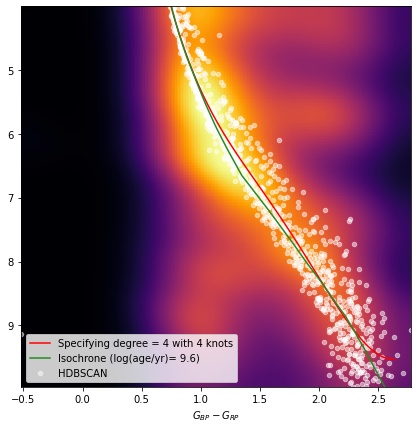

In [134]:
plt.figure(figsize=(7, 7))
post_y = np.delete(data_y, [1081])
az.plot_kde(data_x, post_y, contour=False, pcolormesh_kwargs={'cmap': 'inferno'})
plt.scatter(data_x, data_y, facecolor='None', c='w', alpha=0.5, s = 20, label=r"HDBSCAN")
plt.plot(range_pred, prediction, color='r', label='Specifying degree = '+str(degree)+' with '+str(knots)+' knots')
plt.plot(df1['bp_rp'], df1['Gmag'], color='forestgreen',  label=r"Isochrone (log(age/yr)= 9.6)")
plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.legend()
plt.gca().invert_yaxis()

## Result (Report)

We used HDBSCAN to separate the members of m67 from the background stars. We can see the isolated members of m67 in the Spatial Distribution diagram. The points are very close together in the Vector Point Diagram which also suggests that the stars are indeed the members of the m67 cluster.

From the parallax distribution, we can see that the members of the m67 cluster have a sharp peak in their parallax distribution which indicates the distance from the earth can be well defined.

We generated isochrones from CMD 3.5 input form and observed which isochrone is the best fit for the Color Magnitude Diagram of m67. The value of metal fraction Z is 0.021 and log(age/yr) is 9.6 for the best-fit isochrone. So the actual value should be somewhere around these values. And the log(age/yr) suggests that the age of m67 is 3.98 billion years old which matches the confirmed result(webda and wikipedia). 

For determining distance we plotted histogram for 1/parallax values of the stars and saw most of the stars are lying between 840 parsecs and 900 parsecs. The mean of the distances is 870.35 with a standard deviation of 61.58 parsecs. These results also match with the confirmed results(webda).

And we also did non-linear regression called spline regression using specifying degree 4 with 4 knots. The spline regression line is very close to the best-fit isochrone which again confirms the authenticity of the best-fit isochrone.